# Online learning of a dictionary of parts of faces

This example uses a large dataset of faces to learn a set of 20 x 20 images patches that constitute faces.

From the programming standpoint, it is interesting because it shows how to use the online API of the scikit-learn to process a very large dataset by chunks. The way we proceed is that we load an image at a time and extract randomly 50 patches from this image. Once we have accumulated 500 of these patches (using 10 images), we run the partial_fit method of the online KMeans object, MiniBatchKMeans.

The verbose setting on the MiniBatchKMeans enables us to see that some clusters are reassigned during the successive calls to partial-fit. This is because the number of patches that they represent has become too low, and it is better to choose a random new cluster.

In [1]:
from sklearn import datasets

faces = datasets.fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/mila/s/sara.ebrahim-elkafrawy/scikit_learn_data


In [3]:
import time

import numpy as np

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

print("Learning the dictionary... ")
random_state = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=81, random_state=random_state, verbose=True)
patch_size = (20, 20)


Learning the dictionary... 


In [4]:
t0 = time.time()

# The online learning part: cycle over the whole dataset 6 times
index = 0
buffer = []

for _ in range(6):
    for img in faces.images:
        data = extract_patches_2d(img, patch_size, max_patches=50, random_state=random_state)
        data = np.reshape(data, (len(data), -1))
        buffer.append(data)
        index += 1
        if index % 10 == 0:
            data = np.concatenate(buffer, axis=0)
            data -= np.mean(data, axis=0)
            data /= np.std(data, axis=0)
            kmeans.partial_fit(data)
            buffer = []
        if index % 100 == 0:
            print("Partial fit of %4i out of %i" % (index, 6 * len(faces.images)))

dt = time.time() - t0
print("done in %.2fs." % dt)

[MiniBatchKMeans] Reassigning 11 cluster centers.
Partial fit of  100 out of 2400
Partial fit of  200 out of 2400
Partial fit of  300 out of 2400
Partial fit of  400 out of 2400
Partial fit of  500 out of 2400
Partial fit of  600 out of 2400
[MiniBatchKMeans] Reassigning 2 cluster centers.
Partial fit of  700 out of 2400
Partial fit of  800 out of 2400
Partial fit of  900 out of 2400
Partial fit of 1000 out of 2400
Partial fit of 1100 out of 2400
Partial fit of 1200 out of 2400
Partial fit of 1300 out of 2400
Partial fit of 1400 out of 2400
Partial fit of 1500 out of 2400
Partial fit of 1600 out of 2400
Partial fit of 1700 out of 2400
Partial fit of 1800 out of 2400
Partial fit of 1900 out of 2400
Partial fit of 2000 out of 2400
Partial fit of 2100 out of 2400
Partial fit of 2200 out of 2400
Partial fit of 2300 out of 2400
Partial fit of 2400 out of 2400
done in 1.88s.


# Plot the results

-1.3439441
1.1172686


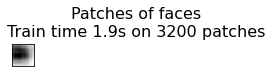

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.2, 4))
for i, patch in enumerate(kmeans.cluster_centers_):
    plt.subplot(9, 9, i + 1)
    plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
    print(patch.min())
    print(patch.max())
    break

plt.suptitle(
    "Patches of faces\nTrain time %.1fs on %d patches" % (dt, 8 * len(faces.images)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

# Try with small GeoLife

In [1]:
import os
import sys
import inspect
import pandas as pd
from pathlib import Path

CURR_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
PARENT_DIR = os.path.dirname(CURR_DIR)
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing")

In [2]:
from dataset.pytorch_dataset import GeoLifeCLEF2022Dataset
from torch.utils.data import random_split, DataLoader

In [3]:
data_dir = "/network/scratch/s/sara.ebrahim-elkafrawy/small_geo_data"  # "/network/scratch/s/sara.ebrahim-elkafrawy/" 
split = "train"
use_ffcv_loader = False
bands = ["rgb"] 
batch_size = 1
num_workers = 0
patch_size = (7, 7)
num_feats = 64  # also number of patches

In [4]:
geo_train_dataset = GeoLifeCLEF2022Dataset(
                root=data_dir,
                subset=split,
                use_ffcv_loader=use_ffcv_loader,
                region="both",
                patch_data=bands,
                use_rasters=False,
                patch_extractor=None,
                transform=None,
                target_transform=None,
                opts=None,
            )

geo_train_loader = DataLoader(
                geo_train_dataset,
                batch_size=batch_size,
                num_workers=num_workers,
                shuffle=True,
                pin_memory=True,
            )

In [5]:
len(geo_train_loader)

2004

In [6]:
import time

import numpy as np

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

print("Learning the dictionary... ")
kmeans_bs = 1024

random_state = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=num_feats, 
                         random_state=random_state,
#                          max_no_improvement=5,
#                          tol=0.01,
#                          max_iter=5,
#                          batch_size = kmeans_bs,
                         verbose=True)

Learning the dictionary... 


In [7]:
t0 = time.time()

# The online learning part: cycle over the whole dataset 6 times
index = 0
buffer = []
num_iters = 6
max_patches = 50

for _ in range(num_iters):
    for batch in geo_train_loader:
    #     rand_img_idx = np.random.randint(batch_size)
    #     curr_batch_size = batch[0]['rgb'].shape[0]
    #     if rand_img_idx > curr_batch_size:
    #         rand_img_idx = curr_batch_size-1

    #     img_np = batch[0]['rgb'][rand_img_idx].numpy()
        patches, target, meta = batch
        img_np = patches['rgb'].numpy()
        img_np = img_np.squeeze(0)
        
        img_np = np.einsum('ijk->jki', img_np)

        data = extract_patches_2d(img_np, patch_size, max_patches=max_patches, random_state=random_state)
        data = np.reshape(data, (len(data), -1))
        buffer.append(data)
        index += 1
        if index % int(len(geo_train_loader)/10) == 0:
            data = np.concatenate(buffer, axis=0)
            data -= np.mean(data, axis=0)
            data /= np.std(data, axis=0)
            kmeans.partial_fit(data)
            buffer = []
    #             print(f'inertia: {kmeans.inertia_}')
        if index % 10000 == 0:
            print("Partial fit of %4i out of %i" % (index, num_iters * len(geo_train_loader)))

dt = time.time() - t0
print("done in %.2fs." % dt)

Partial fit of 10000 out of 12024
done in 59.65s.


In [8]:
# done in 44132.36s.  whole dataset
kmeans.cluster_centers_.min()

-1.9083264

In [9]:
# save_path = '/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/mosaik_geo_filters/'
# np.save(os.path.join(save_path, 'kmeans_512_small.npy'), kmeans.cluster_centers_.reshape(-1, 3, patch_size[0], patch_size[0]))

In [10]:
# kmeans_np = np.load('kmeans_64_whole.npy')
# dt = 44132.36

In [11]:
# buffer[0].shape, kmeans.cluster_centers_.shape

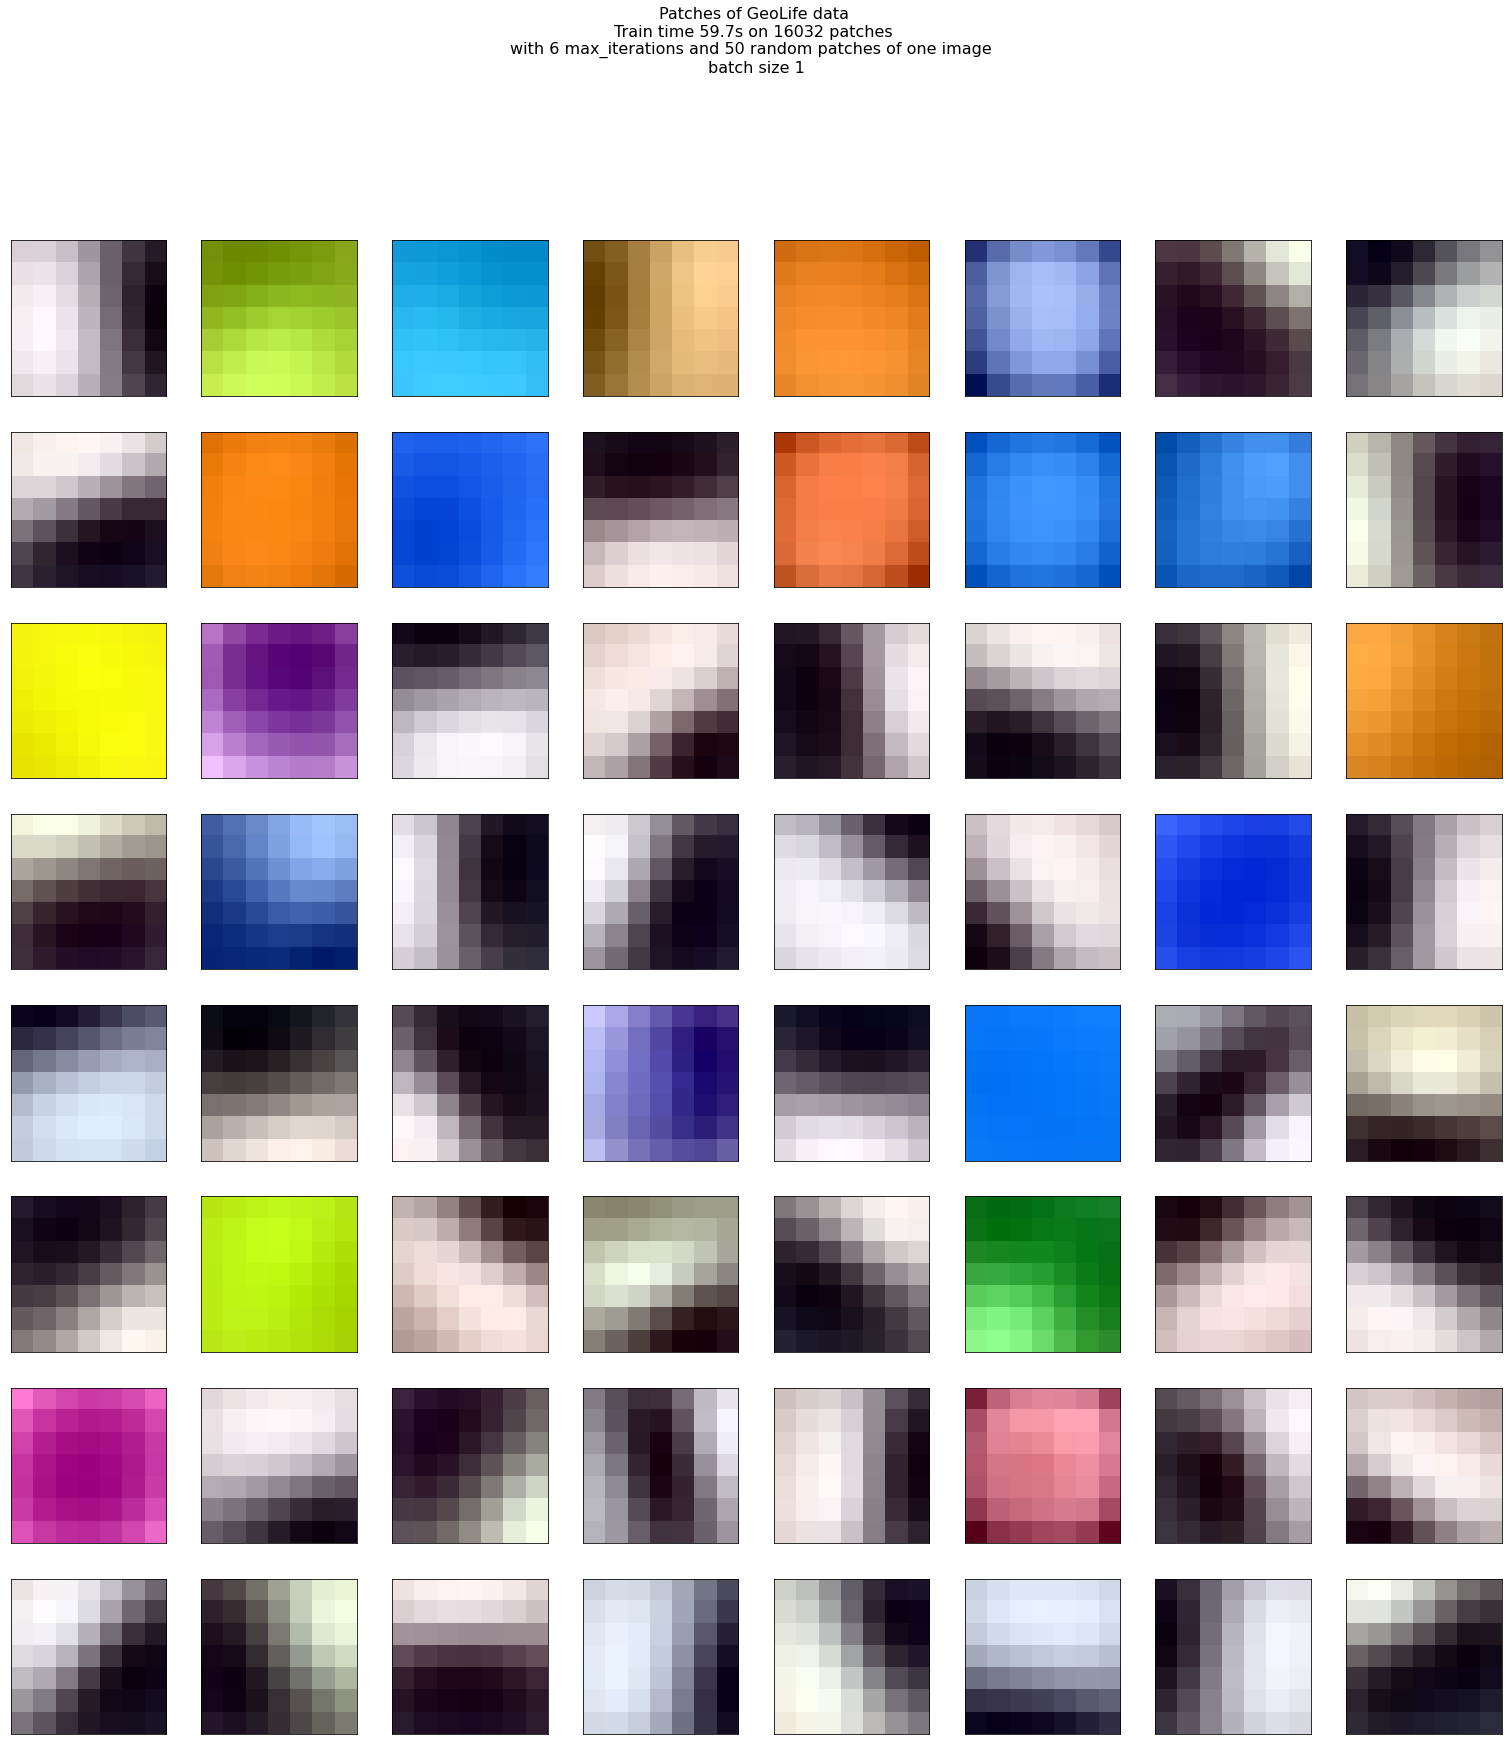

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 25))
for i, patch in enumerate(kmeans.cluster_centers_):
    plt.subplot(8, 8, i + 1)
    img = patch.reshape(patch_size[0], patch_size[1],3)
    img = (img- np.amin(img))/(np.amax(img)-np.amin(img))
    img = np.clip(img, 0, 1)
    plt.imshow(img) #interpolation="nearest")
    plt.xticks(())
    plt.yticks(())


plt.suptitle(
    "Patches of GeoLife data \nTrain time %.1fs on %d patches \nwith %d max_iterations and %d random patches of one image  \nbatch size %d" \
    % (dt, 8 * len(geo_train_loader), num_iters, max_patches, batch_size),
    fontsize=16,

)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.rcParams['savefig.facecolor']='white'
plt.savefig('patches_1st_layer.png')

In [83]:
# np.save('kmeans_64_whole.npy', kmeans.cluster_centers_)

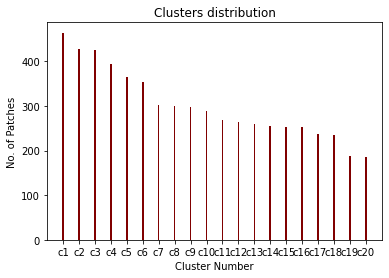

In [15]:
lbls = kmeans.labels_
lbls_df = pd.DataFrame(lbls, index=None)
lbls_lst = list(lbls_df.value_counts().values)
x_vals = [f'c{cluster_num}' for cluster_num in range(1,65)]

plt.bar(x_vals[:20], lbls_lst[:20], color ='maroon', width = 0.1)
plt.xlabel("Cluster Number")
plt.ylabel("No. of Patches")
plt.title("Clusters distribution")
plt.rcParams['savefig.facecolor']='white'
plt.savefig('clusters_distribution.png')

In [21]:
lbls_lst

[3256,
 3141,
 2783,
 2758,
 2517,
 2469,
 2314,
 1925,
 1871,
 1850,
 1822,
 1714,
 1622,
 1577,
 1459,
 1419,
 1356,
 1282,
 1241,
 1232,
 1048,
 896,
 851,
 807,
 775,
 740,
 731,
 705,
 704,
 672,
 650,
 640,
 635,
 605,
 573,
 564,
 559,
 558,
 477,
 454,
 453,
 451,
 450,
 448,
 438,
 437,
 434,
 425,
 410,
 409,
 408,
 398,
 389,
 352,
 351,
 345,
 332,
 322,
 310,
 269,
 264,
 236,
 221,
 196]

In [14]:
lbls[0]

42

In [17]:
len(lbls_np)

64

# Extract random patches

In [1]:
import os
import sys
import time
import inspect
import numpy as np
from pathlib import Path
from sklearn.feature_extraction.image import extract_patches_2d

CURR_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
PARENT_DIR = os.path.dirname(CURR_DIR)
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing")

from dataset.pytorch_dataset import GeoLifeCLEF2022Dataset
from torch.utils.data import random_split, DataLoader

random_state = np.random.RandomState(0)

In [2]:
data_dir ="/network/scratch/s/sara.ebrahim-elkafrawy/"  #"/network/scratch/s/sara.ebrahim-elkafrawy/small_geo_data" 
split = "train"
use_ffcv_loader = False
bands = ["rgb"] 
batch_size = 1
num_workers = 0
patch_size = (10, 10)
num_feats = 64  # also number of patches

In [3]:
geo_train_dataset = GeoLifeCLEF2022Dataset(
                root=data_dir,
                subset=split,
                use_ffcv_loader=use_ffcv_loader,
                region="both",
                patch_data=bands,
                use_rasters=False,
                patch_extractor=None,
                transform=None,
                target_transform=None,
                opts=None,
            )

geo_train_loader = DataLoader(
                geo_train_dataset,
                batch_size=batch_size,
                num_workers=num_workers,
                shuffle=True,
                pin_memory=True,
            )

In [4]:
len(geo_train_loader)/batch_size

1587395.0

In [5]:
random_indices = np.random.randint(int(len(geo_train_loader)/batch_size), size=num_feats)
random_indices = np.sort(random_indices)

In [6]:
random_indices

array([   8650,   12323,   42022,   44540,   55869,   70031,  130105,
        155111,  172898,  173358,  181383,  204792,  255881,  258551,
        286878,  288480,  289018,  310580,  322334,  351150,  380900,
        425373,  433184,  433725,  474171,  492060,  493824,  513643,
        517400,  530652,  531283,  575773,  579390,  580400,  624957,
        644673,  675433,  705626,  718594,  726891,  753821,  794691,
        844035,  854665,  857475,  861714,  899347,  942282,  943779,
        953065,  955624,  971702,  975295,  985683, 1044476, 1117779,
       1134949, 1294805, 1347399, 1426042, 1482009, 1489213, 1555243,
       1585998])

In [7]:
len(random_indices)

64

In [8]:
t0 = time.time()


# The online learning part: cycle over the whole dataset 6 times
rand_idx = 0

buffer = []


for batch_idx, batch in enumerate(geo_train_loader):
    if batch_idx == random_indices[rand_idx]:
        patches, target, meta = batch
        img_np = patches['rgb'].numpy()
        img_np = img_np.squeeze(0)
        img_np = np.einsum('ijk->jki', img_np)

        data = extract_patches_2d(img_np, patch_size, max_patches=1, random_state=random_state)
        data = np.reshape(data, (len(data), -1))
        buffer.append(data)

        rand_idx += 1
    if rand_idx == len(random_indices):
        break

dt = time.time() - t0
print("done in %.2fs." % dt)

done in 6827.39s.


## visualize the random patches

In [9]:
buffer[63].shape, len(buffer)

((1, 300), 64)

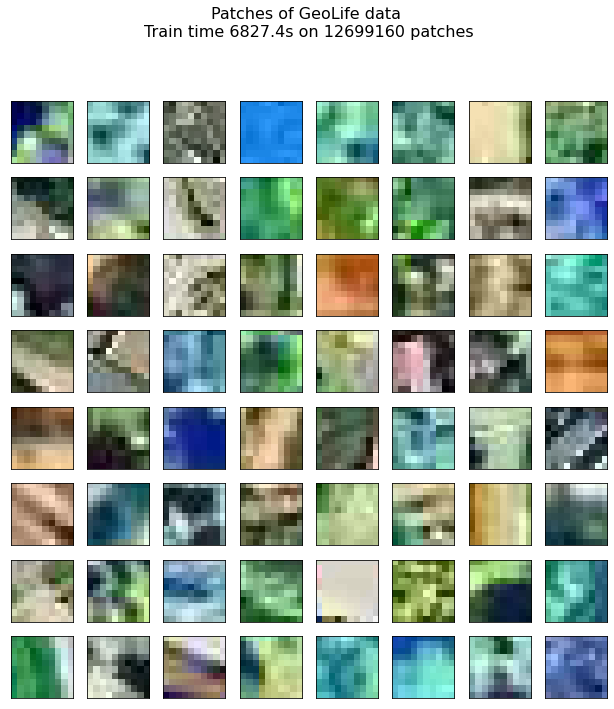

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, patch in enumerate(buffer):
    plt.subplot(8, 8, i + 1)
    img = patch.reshape(patch_size[0], patch_size[1],3)
    img = (img- np.amin(img))/(np.amax(img)-np.amin(img))
#     img = np.clip(img, 0, 1)
    plt.imshow(img) #interpolation="nearest")
    plt.xticks(())
    plt.yticks(())


plt.suptitle(
    "Patches of GeoLife data \nTrain time %.1fs on %d patches" % (dt, 8 * len(geo_train_loader)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

# plt.show()
plt.savefig('patches_1st_layer.png')